# CODE LOAD MÔ HÌNH PYTORCH PTH

CUDA available: True
CUDA device count: 1
Current CUDA device: 0
CUDA device name: NVIDIA GeForce RTX 3070 Ti
CUDA memory allocated: 0.00 MB
CUDA memory reserved: 0.00 MB
Inspecting depth model file structure...
Inspecting model file: kaka.pth
Type of loaded file: <class 'dict'>
Keys in the dictionary: dict_keys(['epoch', 'model_state_dict', 'optimizer_state_dict', 'scheduler_state_dict', 'train_loss', 'val_loss'])
Type of model_state_dict: <class 'collections.OrderedDict'>
Number of layers in model_state_dict: 136
Example keys: ['conv1.0.conv.weight', 'conv1.0.conv.bias', 'conv1.0.batch_norm.weight', 'conv1.0.batch_norm.bias', 'conv1.0.batch_norm.running_mean']
Attempting to load models with GPU...
Using device: cuda
Loading depth model using device: cuda
✅ Depth model loaded successfully
Processing image with GPU...
Original image size: (480, 640)
Input tensor shape: torch.Size([1, 3, 256, 256])
Depth prediction successful

0: 480x640 1 backpack, 1 bed, 159.8ms
Speed: 36.8ms preproce

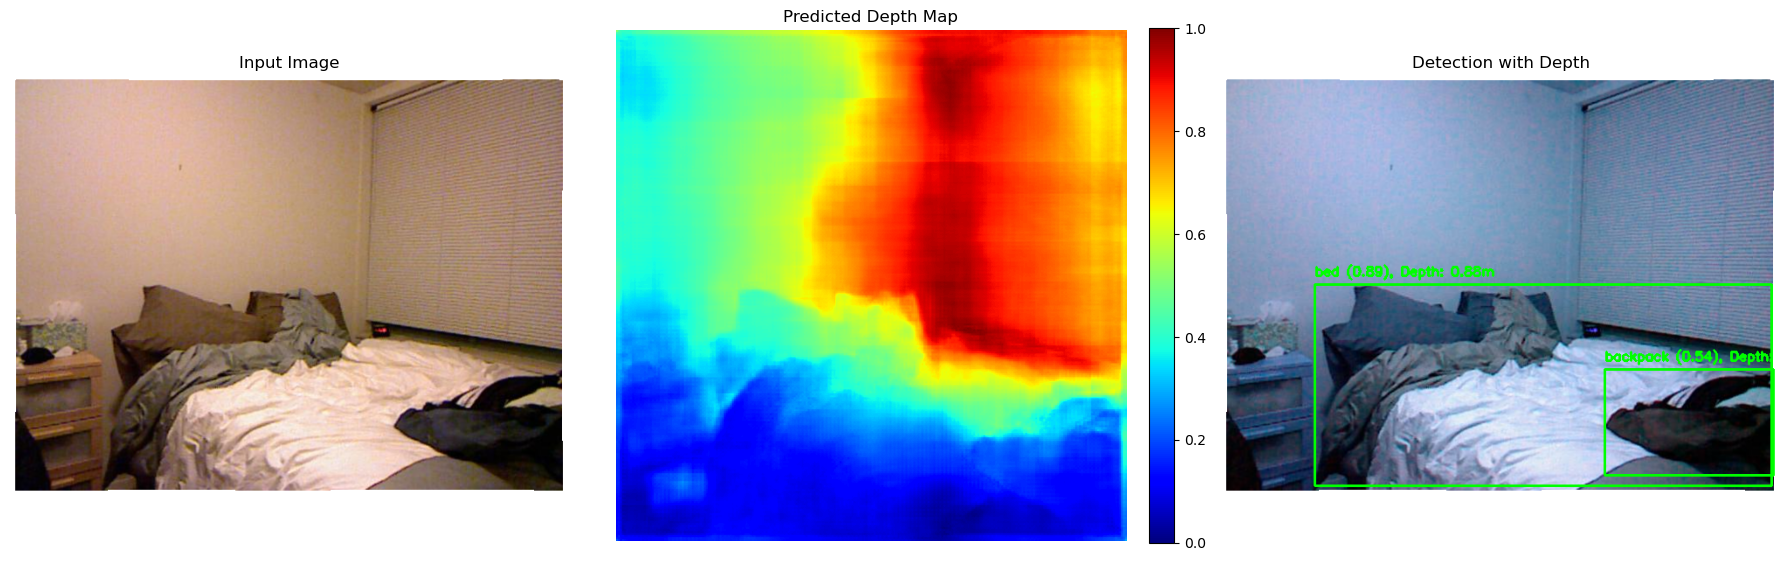

Processing complete. Result saved to test2_depth_detection.png


In [1]:
import os
# Set environment variables for debugging and compatibility
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'  # Add this for better error reporting

import cv2
import numpy as np
import torch
import matplotlib.pyplot as plt
from ultralytics import YOLO
from PIL import Image
import torch.nn as nn
import gc  # For garbage collection
from collections import OrderedDict

class ConvBlock(nn.Sequential):
    def __init__(self, in_c, out_c):
        super().__init__(OrderedDict([
            ('conv',       nn.Conv2d(in_c, out_c, kernel_size=3, padding=1)),
            ('batch_norm', nn.BatchNorm2d(out_c)),
            ('activation', nn.LeakyReLU(0.2, inplace=True)),
        ]))

class DepthEstimationModel(nn.Module):
    def __init__(self):
        super().__init__()
        # Encoder
        self.conv1 = nn.Sequential(ConvBlock(3, 64),   ConvBlock(64, 64))
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Sequential(ConvBlock(64, 128), ConvBlock(128, 128))
        self.pool2 = nn.MaxPool2d(2)
        self.conv3 = nn.Sequential(ConvBlock(128, 256),ConvBlock(256, 256))
        self.pool3 = nn.MaxPool2d(2)
        self.conv4 = nn.Sequential(ConvBlock(256, 512),ConvBlock(512, 512), nn.Dropout(0.5))
        self.pool4 = nn.MaxPool2d(2)

        # Bridge
        self.bridge = nn.Sequential(
            ConvBlock(512, 1024),
            ConvBlock(1024, 1024),
            nn.Dropout(0.5)
        )

        # Decoder
        self.upconv6 = nn.ConvTranspose2d(1024, 512, 2, stride=2)
        self.conv6   = nn.Sequential(ConvBlock(512+512, 512), ConvBlock(512, 512))
        self.upconv7 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.conv7   = nn.Sequential(ConvBlock(256+256, 256), ConvBlock(256, 256))
        self.upconv8 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.conv8   = nn.Sequential(ConvBlock(128+128, 128), ConvBlock(128, 128))
        self.upconv9 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.conv9   = nn.Sequential(ConvBlock(64+64, 64),   ConvBlock(64, 64))

        # Output
        self.output  = nn.Conv2d(64, 1, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        c1 = self.conv1(x); p1 = self.pool1(c1)
        c2 = self.conv2(p1); p2 = self.pool2(c2)
        c3 = self.conv3(p2); p3 = self.pool3(c3)
        c4 = self.conv4(p3); p4 = self.pool4(c4)

        b  = self.bridge(p4)

        u6 = self.upconv6(b)
        m6 = torch.cat([c4, u6], dim=1)
        c6 = self.conv6(m6)

        u7 = self.upconv7(c6)
        m7 = torch.cat([c3, u7], dim=1)
        c7 = self.conv7(m7)

        u8 = self.upconv8(c7)
        m8 = torch.cat([c2, u8], dim=1)
        c8 = self.conv8(m8)

        u9 = self.upconv9(c8)
        m9 = torch.cat([c1, u9], dim=1)
        c9 = self.conv9(m9)

        out = self.output(c9)
        return self.sigmoid(out)

def load_depth_model(path, device=None, strict=True, strip_dp=True):
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    print(f"Loading depth model using device: {device}")
    
    try:
        ckpt = torch.load(path, map_location='cpu')  # Always load to CPU first

        if isinstance(ckpt, dict) and 'model_state_dict' in ckpt:
            state_dict = ckpt['model_state_dict']
        else:
            state_dict = ckpt 

        if strip_dp:
            new_sd = OrderedDict()
            for k, v in state_dict.items():
                new_k = k.replace('module.', '')
                new_sd[new_k] = v
            state_dict = new_sd

        model = DepthEstimationModel()
        missing, unexpected = model.load_state_dict(state_dict, strict=strict)
        
        if missing:
            print("⚠️  Missing keys:", missing)
        if unexpected:
            print("⚠️  Unexpected keys:", unexpected)
        
        # Move model to device after loading weights
        model = model.to(device)
        model.eval()
        print("✅ Depth model loaded successfully")
        return model
    
    except Exception as e:
        print(f"❌ Error loading depth model: {e}")
        return None

def load_models(depth_model_path="model_depth_prediction.pth", yolo_weights="yolov9e.pt", use_cpu=False):
    # Clear CUDA cache before loading models
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        gc.collect()
    
    device = torch.device('cpu') if use_cpu else torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    try:
        depth_model = load_depth_model(depth_model_path, device, strict=False)
    except Exception as e:
        print(f"Error loading depth model: {e}")
        depth_model = None
    
    try:
        # For YOLOv8, specify device
        yolo_model = YOLO(yolo_weights)
        if use_cpu:
            yolo_model.to('cpu')
    except Exception as e:
        print(f"Error loading YOLO model: {e}")
        yolo_model = None
    
    return depth_model, yolo_model

def preprocess_image(image_path, target_size=(256, 256)):
    try:
        if isinstance(image_path, str):
            img = cv2.imread(image_path)
            if img is None:
                raise ValueError(f"Could not read image from {image_path}")
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        else:
            img = image_path
            if len(img.shape) == 3 and img.shape[2] == 3:
                if img.dtype == np.uint8:
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        original_size = img.shape[:2]
        print(f"Original image size: {original_size}")
        
        # Check if image is too large
        if original_size[0] > 1024 or original_size[1] > 1024:
            print("Warning: Large image detected. Consider using a smaller image to prevent memory issues.")
        
        img_resized = cv2.resize(img, target_size, interpolation=cv2.INTER_AREA)
        img_normalized = img_resized / 255.0
        
        return img, img_normalized, original_size
    
    except Exception as e:
        print(f"Error preprocessing image: {e}")
        return None, None, None

def predict_depth(model, img_normalized):
    if model is None:
        print("Warning: No depth model available, generating random depth map")
        return np.random.rand(img_normalized.shape[0], img_normalized.shape[1], 1)
    
    try:
        # Create tensor and ensure it's in the right format
        img_tensor = torch.from_numpy(img_normalized.transpose(2, 0, 1)).float().unsqueeze(0)
        
        # Get device from the model
        device = next(model.parameters()).device
        img_tensor = img_tensor.to(device)
        
        # Check tensor shape
        print(f"Input tensor shape: {img_tensor.shape}")
        
        with torch.no_grad():
            try:
                # Set to eval mode to be sure
                model.eval()
                depth_map = model(img_tensor)
                print("Depth prediction successful")
            except RuntimeError as e:
                print(f"CUDA error during depth prediction: {e}")
                print("Trying with CPU instead...")
                
                # Move model and data to CPU and try again
                model = model.to('cpu')
                img_tensor = img_tensor.to('cpu')
                
                model.eval()
                depth_map = model(img_tensor)
                print("Depth prediction successful on CPU")
        
        depth_map = depth_map.cpu().numpy()
        
        if len(depth_map.shape) == 4:  # [B, C, H, W]
            depth_map = depth_map[0].transpose(1, 2, 0)  # [H, W, C]
        elif len(depth_map.shape) == 3:  # [B, H, W]
            depth_map = depth_map[0]
            depth_map = np.expand_dims(depth_map, axis=-1)  
        
        # Normalize depth map
        depth_min, depth_max = depth_map.min(), depth_map.max()
        if depth_min != depth_max:  # Avoid division by zero
            depth_map = (depth_map - depth_min) / (depth_max - depth_min + 1e-8)
        
        return depth_map
    
    except Exception as e:
        print(f"Error in depth prediction: {e}")
        return np.zeros((img_normalized.shape[0], img_normalized.shape[1], 1))

def detect_objects(yolo_model, img):
    if yolo_model is None:
        print("Warning: No YOLO model available, skipping object detection")
        return None
    
    try:
        results = yolo_model(img)
        return results[0]
    except Exception as e:
        print(f"Error in object detection: {e}")
        return None

def get_depth_at_position(depth_map, x, y, box_width, box_height, original_size, target_size=(256, 256)):
    try:
        scale_y = target_size[0] / original_size[0]
        scale_x = target_size[1] / original_size[1]
        
        scaled_y = int(y * scale_y)
        scaled_x = int(x * scale_x)
        scaled_h = max(1, int(box_height * scale_y))
        scaled_w = max(1, int(box_width * scale_x))
        
        # Ensure positions are within bounds
        scaled_y = min(max(0, scaled_y), target_size[0] - 1)
        scaled_x = min(max(0, scaled_x), target_size[1] - 1)
        
        region_y = min(scaled_y + scaled_h // 2, target_size[0] - 1)
        region_x = min(scaled_x + scaled_w // 2, target_size[1] - 1)
        
        depth_value = depth_map[region_y, region_x, 0]
        
        # Convert depth value to meters (scaling factor can be adjusted)
        depth_in_meters = depth_value * 10.0
        
        return depth_in_meters
    
    except Exception as e:
        print(f"Error getting depth at position: {e}")
        return 0.0

def visualize_results(img, depth_map, detections, original_size, target_size=(256, 256)):
    try:
        depth_colormap = cv2.applyColorMap(
            (depth_map.squeeze() * 255).astype(np.uint8), 
            cv2.COLORMAP_JET
        )
        
        depth_colormap_resized = cv2.resize(depth_colormap, (original_size[1], original_size[0]))
        
        detection_img = img.copy()
        
        if detections is not None:
            boxes = detections.boxes.xyxy.cpu().numpy()
            confs = detections.boxes.conf.cpu().numpy()
            cls_ids = detections.boxes.cls.cpu().numpy().astype(int)
            class_names = detections.names
            
            for box, conf, cls_id in zip(boxes, confs, cls_ids):
                x1, y1, x2, y2 = box.astype(int)
                label = class_names[cls_id]
                
                center_x = (x1 + x2) // 2
                center_y = (y1 + y2) // 2
                box_width = x2 - x1
                box_height = y2 - y1
                
                depth_value = get_depth_at_position(
                    depth_map, center_x, center_y, box_width, box_height, 
                    original_size, target_size
                )
                
                cv2.rectangle(detection_img, (x1, y1), (x2, y2), (0, 255, 0), 2)
                
                label_text = f"{label} ({conf:.2f}), Depth: {depth_value:.2f}m"
                cv2.putText(
                    detection_img, label_text, (x1, y1 - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2
                )
        
        fig, axes = plt.subplots(1, 3, figsize=(18, 6))
        
        axes[0].imshow(img)
        axes[0].set_title("Input Image")
        axes[0].axis("off")
        
        im = axes[1].imshow(depth_map.squeeze(), cmap='jet', vmin=0, vmax=1)
        axes[1].set_title("Predicted Depth Map")
        axes[1].axis("off")
        fig.colorbar(im, ax=axes[1], fraction=0.046, pad=0.04)
        
        axes[2].imshow(cv2.cvtColor(detection_img, cv2.COLOR_BGR2RGB))
        axes[2].set_title("Detection with Depth")
        axes[2].axis("off")
        
        plt.tight_layout()
        return fig
    
    except Exception as e:
        print(f"Error in visualization: {e}")
        return None

def process_image(image_path, depth_model, yolo_model, output_path=None, show_plot=True, use_cpu=False):
    # Preprocess image
    img_original, img_normalized, original_size = preprocess_image(image_path)
    if img_original is None:
        return None, None
    
    # If still on GPU and facing issues, try CPU
    if not use_cpu and torch.cuda.is_available():
        try:
            depth_map = predict_depth(depth_model, img_normalized)
        except RuntimeError as e:
            print(f"GPU error in depth prediction: {e}")
            print("Falling back to CPU for depth prediction...")
            # Move model to CPU
            if depth_model is not None:
                depth_model = depth_model.to('cpu')
            depth_map = predict_depth(depth_model, img_normalized)
    else:
        depth_map = predict_depth(depth_model, img_normalized)
    
    # Object detection
    try:
        detections = detect_objects(yolo_model, img_original)
    except Exception as e:
        print(f"Error in object detection: {e}")
        detections = None
    
    # Visualization
    fig = visualize_results(img_original, depth_map, detections, original_size)
    
    if fig is not None and output_path:
        try:
            plt.savefig(output_path, bbox_inches='tight')
            print(f"Result saved to {output_path}")
        except Exception as e:
            print(f"Error saving result: {e}")
    
    if show_plot and fig is not None:
        plt.show()
    elif fig is not None:
        plt.close(fig)
    
    return depth_map, detections

def inspect_depth_model_file(model_path):
    print(f"Inspecting model file: {model_path}")
    
    if not os.path.exists(model_path):
        print(f"Error: Model file {model_path} does not exist")
        return False
    
    try:
        state_dict = torch.load(model_path, map_location=torch.device('cpu'))
        print(f"Type of loaded file: {type(state_dict)}")
        
        if isinstance(state_dict, dict):
            print(f"Keys in the dictionary: {state_dict.keys()}")
            
            if 'state_dict' in state_dict:
                print(f"Type of state_dict: {type(state_dict['state_dict'])}")
                print(f"Number of layers in state_dict: {len(state_dict['state_dict'])}")
                print(f"Example keys: {list(state_dict['state_dict'].keys())[:5]}")
            elif 'model_state_dict' in state_dict:
                print(f"Type of model_state_dict: {type(state_dict['model_state_dict'])}")
                print(f"Number of layers in model_state_dict: {len(state_dict['model_state_dict'])}")
                print(f"Example keys: {list(state_dict['model_state_dict'].keys())[:5]}")
            
            if 'model_def' in state_dict:
                print(f"Model definition found: {state_dict['model_def']}")
            
            if any(k.endswith('.weight') for k in state_dict.keys()):
                print(f"Number of layers: {len(state_dict)}")
                print(f"Example keys: {list(state_dict.keys())[:5]}")
        
        return True
    except Exception as e:
        print(f"Error inspecting model file: {e}")
        return False

def check_cuda_status():
    """Check CUDA availability and print device information"""
    print("CUDA available:", torch.cuda.is_available())
    
    if torch.cuda.is_available():
        print("CUDA device count:", torch.cuda.device_count())
        print("Current CUDA device:", torch.cuda.current_device())
        print("CUDA device name:", torch.cuda.get_device_name(0))
        
        # Check memory
        try:
            print(f"CUDA memory allocated: {torch.cuda.memory_allocated(0) / 1024**2:.2f} MB")
            print(f"CUDA memory reserved: {torch.cuda.memory_reserved(0) / 1024**2:.2f} MB")
        except Exception as e:
            print(f"Error getting CUDA memory info: {e}")

def main():
    # First, check CUDA status
    check_cuda_status()
    
    depth_model_path = "kaka.pth"
    
    print("Inspecting depth model file structure...")
    inspect_depth_model_file(depth_model_path)
    
    # First try with GPU
    try:
        print("Attempting to load models with GPU...")
        depth_model, yolo_model = load_models(depth_model_path, use_cpu=False)
    except RuntimeError as e:
        print(f"Error loading models with GPU: {e}")
        print("Falling back to CPU...")
        depth_model, yolo_model = load_models(depth_model_path, use_cpu=True)
    
    if depth_model is None:
        print("Failed to load depth estimation model. Exiting.")
        return
    
    if yolo_model is None:
        print("Failed to load YOLO model. Exiting.")
        return
    
    image_path = input("Enter the path to the image: ")
    if not os.path.exists(image_path):
        print(f"Image not found: {image_path}")
        return
    
    output_path = image_path.rsplit('.', 1)[0] + "_depth_detection.png"
    
    # First try processing with GPU
    try:
        print("Processing image with GPU...")
        depth_map, detections = process_image(
            image_path, depth_model, yolo_model, output_path=output_path, use_cpu=False
        )
    except RuntimeError as e:
        print(f"Error processing with GPU: {e}")
        print("Falling back to CPU for processing...")
        # Move models to CPU
        if depth_model is not None:
            depth_model = depth_model.to('cpu')
        if yolo_model is not None:
            yolo_model.to('cpu')
        
        depth_map, detections = process_image(
            image_path, depth_model, yolo_model, output_path=output_path, use_cpu=True
        )
    
    print(f"Processing complete. Result saved to {output_path}")

if __name__ == "__main__":
    main()